In [1]:
import os
import os.path
import glob
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
import sklearn_evaluation.plot as skplot
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'cg-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from cg-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9700, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [21]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
tprs = []
aucs = []
y_all_test = []
y_all_pred = []
y_all_score0 = []
y_all_score1 = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    y_train = y[train_indices]
    X_test = resnet50features[test_indices]
    y_test = y[test_indices]
    
    top_model = svm.SVC(C=10.0, gamma=0.001, probability=True)
    start = time.time()
    top_model.fit(X_train,y_train)  # Training
    end = time.time()
    y_pred = top_model.predict(X_test)  # Testing
    y_score = top_model.predict_proba(X_test)
    
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix
    y_all_test = np.hstack((y_all_test,y_test))
    y_all_pred = np.hstack((y_all_pred,y_pred))
    y_all_score0 = np.hstack((y_all_score0,y_score[:,0]))
    y_all_score1 = np.hstack((y_all_score1,y_score[:,1]))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc) 

[0] Test acurracy: 0.9418 (434.9251 s)
[1] Test acurracy: 0.9361 (426.4032 s)
[2] Test acurracy: 0.9500 (439.2395 s)
[3] Test acurracy: 0.9340 (424.9398 s)
[4] Test acurracy: 0.9443 (427.3913 s)


In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9412


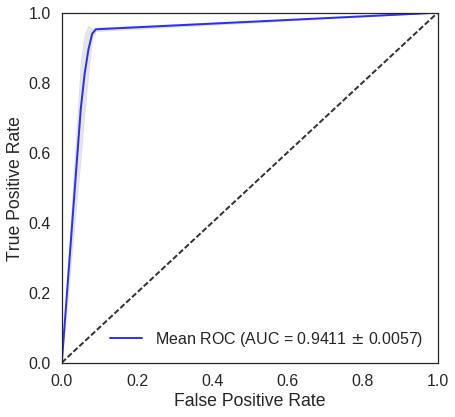

In [12]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-white')

figure = plt.gcf()
figure.set_size_inches(6, 6)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=.2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('SVM-ROCCurve_Average.pdf', format='pdf')
plt.show()

In [13]:
average_precision = average_precision_score(y_all_test, y_all_score1)
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Average precision-recall score: 0.9844


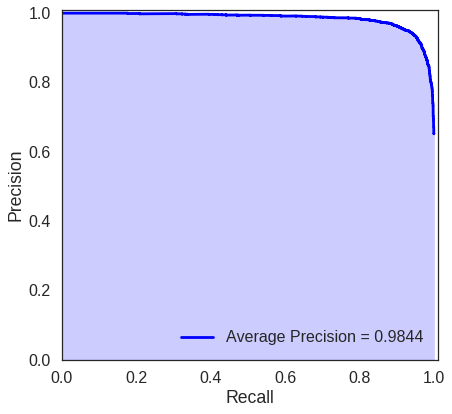

In [14]:
figure = plt.gcf()
figure.set_size_inches(6, 6)

precision, recall, _ = precision_recall_curve(y_all_test, y_all_score1)

plt.step(recall, precision, color='b', where='post', label=r'Average Precision = %0.4f' %(average_precision))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.legend(loc="lower right")
plt.savefig('SVM-PrecisionRecallCurve_Average.pdf', format='pdf')
plt.show()

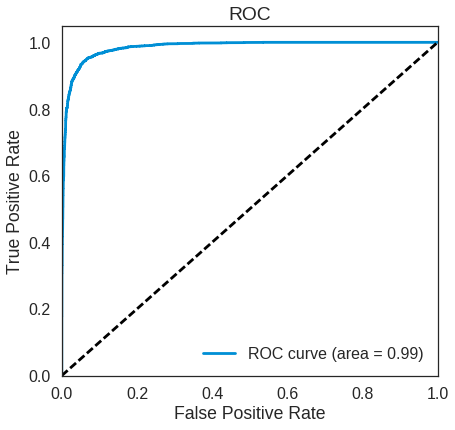

In [15]:
skplot.roc(y_all_test, y_all_score1)
figure = plt.gcf()
figure.set_size_inches(6, 6)
plt.savefig('SVM-ROCCurve.pdf', format='pdf')
plt.show()

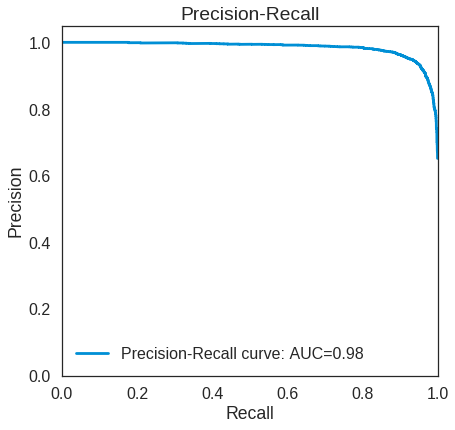

In [16]:
skplot.precision_recall(y_all_test, y_all_score1)
figure = plt.gcf()
figure.set_size_inches(6, 6)
plt.savefig('SVM-PrecisionRecallCurve.pdf', format='pdf')
plt.show()

Plotting the confusion matrix normalized


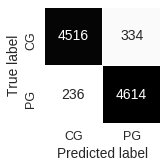

In [17]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(2, 2)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('SVM-ConfusionMatrix.pdf', format='pdf')
plt.show()

Plotting the confusion matrix normalized


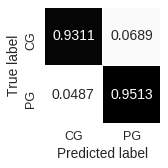

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(2, 2)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('SVM-ConfusionMatrixNormalized.pdf', format='pdf')
plt.show()

In [19]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=10.0,gamma=0.001)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

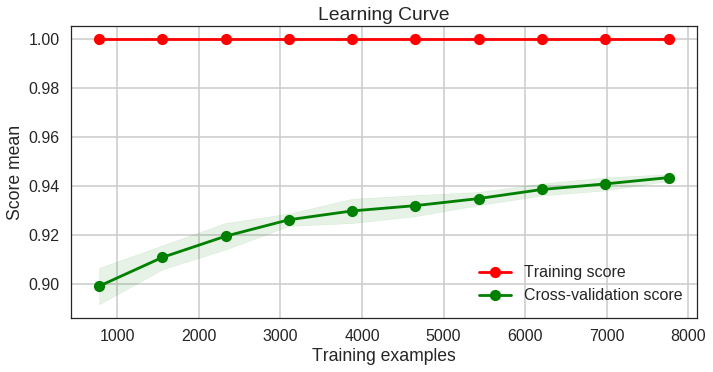

In [20]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-white')
figure = plt.gcf()
figure.set_size_inches(10, 5)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('SVM-LearningCurve.pdf', format='pdf')
plt.show()